<a href="https://colab.research.google.com/github/rubanzasilva/academic_success/blob/main/s04e06_fastai%2BGBT_exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification model to predict students' dropout and academic sucess.

The dataset contains information collected from a higher education institution related to students undertaking different degree programs.
The original dataset contains information known at the time of student enrollment and the student's academic perfromance at the end of the 1st and 2nd semester.

The target is split into three distinct categories namely Dropout, Enrolled and Graduate.

In this spirit, I shall build classification models using various architectures to predict the student's dropout and academic success.This can then be used to predict which students are most likely to drop out at an early stage so that strategies can be put in place to counter this.

That would help reduce the rate of academic dropout and failure.

## Import Libraries and Datasets

### Libraries

### Original Dataset

@misc{misc_predict_students'_dropout_and_academic_success_697,
  author       = {Realinho,Valentim, Vieira Martins,Mónica, Machado,Jorge, and Baptista,Luís},
  title        = {{Predict Students' Dropout and Academic Success}},
  year         = {2021},
  howpublished = {UCI Machine Learning Repository},
  note         = {{DOI}: https://doi.org/10.24432/C5MC89}
}

## Imports

Below, i import all the libraries and datasets needed for this competition.

In [1]:
!pip install catboost
!pip install optuna
!pip install optuna_distributed
!pip install openfe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.1 MB/s eta 0:00:00


In [2]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

#from fastkaggle import setup_comp

import optuna
from openfe import OpenFE, transform

from IPython.display import FileLink



In [3]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubanzasilva","key":"3c109650146efc9c92fc9e8bfe70d487"}'}

In [5]:
!ls

kaggle.json  sample_data


In [6]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

#!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!pip freeze > requirements.txt

In [8]:
!ls

kaggle.json  requirements.txt  sample_data


In [9]:
comp = 'playground-series-s4e6'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 3.07M/3.07M [00:00<00:00, 108MB/s]

In [10]:
#set_seed(42)

In [11]:
path = Path('playground-series-s4e6/')
path

Path('playground-series-s4e6')

### Import original dataset

In [12]:
!kaggle datasets download -d ramjaslangdi/students-dropout-and-academic-success

Dataset URL: https://www.kaggle.com/datasets/ramjaslangdi/students-dropout-and-academic-success
License(s): Apache 2.0
  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 89.5MB/s]


In [13]:
!ls

kaggle.json		playground-series-s4e6.zip  sample_data
playground-series-s4e6	requirements.txt	    students-dropout-and-academic-success.zip


In [ ]:
!unzip students-dropout-and-academic-success.zip

Archive:  students-dropout-and-academic-success.zip
  inflating: data.csv                


In [ ]:
!unzip academic-success-dataset.zip

In [14]:
! kaggle datasets download -d rubanzasilva/academic-success-dataset

Dataset URL: https://www.kaggle.com/datasets/rubanzasilva/academic-success-dataset
License(s): Apache 2.0
  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 60.2MB/s]


In [15]:
!unzip academic-success-dataset.zip

Archive:  academic-success-dataset.zip
  inflating: data.csv                


In [16]:
!ls

academic-success-dataset.zip  playground-series-s4e6	  sample_data
data.csv		      playground-series-s4e6.zip  students-dropout-and-academic-success.zip
kaggle.json		      requirements.txt


# Adding original dataset

In [17]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
#original_df = pd.read_csv('data.csv')
original_df = pd.read_csv('data.csv')
#original_df = pd.read_csv('data.csv', delimiter=';')

In [24]:
original_df.rename(columns={'Daytime/evening attendance\t':'Daytime/evening attendance'}, inplace=True)

In [25]:
train_final = pd.concat([train_df,original_df], axis=0)
test_final = pd.concat([test_df,original_df], axis=0)
train_final.shape,train_df.shape

((80942, 38), (76518, 37))

In [27]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Target')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Target',
                   y_block=CategoryBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

In [28]:
from openfe import OpenFE, transform

ofe = OpenFE()

In [29]:
features = ofe.fit(data=X_train, label=y_train, n_jobs=n_jobs)  # generate new features

NameError: name 'n_jobs' is not defined

In [30]:

train_x, test_x = transform(X_train, y_train, features, n_jobs=n_jobs) # transform the train and test data according to generated features

NameError: name 'features' is not defined

In [ ]:
%%time
rf = RandomForestClassifier(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

accuracy_score(y_test,rf_preds_x)

CPU times: user 17 s, sys: 99.5 ms, total: 17.1 s
Wall time: 18.7 s


0.8251791450457129

In [ ]:
%%time
cat_model = CatBoostClassifier(iterations=2000, depth=8, learning_rate=  0.08, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

cat_preds_y = cat_preds.squeeze(1)

accuracy_score(y_test,cat_preds_x)

CPU times: user 8min 21s, sys: 5.11 s, total: 8min 26s
Wall time: 5min 35s


0.8277736595008648

In [ ]:
%%time
xgb_model = xgb.XGBClassifier(n_estimators = 197, max_depth=4, learning_rate=0.1818695751227044, subsample= 0.39774994666482544)
xgb_model = xgb_model.fit(X_train, y_train)
xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

accuracy_score(y_test,xgb_preds_x)


CPU times: user 7.65 s, sys: 21.9 ms, total: 7.67 s
Wall time: 7.76 s


0.8290091425747467

In [ ]:
lgb_model = lgb.LGBMClassifier(num_leaves=251, learning_rate=0.02956613668999794, n_estimators=483, max_depth=82, boosting_type='gbdt',min_child_samples=90, random_state=27)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = accuracy_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 64754, number of used features: 36
[LightGBM] [Info] Start training from score -1.106177
[LightGBM] [Info] Start training from score -1.640875
[LightGBM] [Info] Start training from score -0.743665


0.8257968865826538

In [ ]:
general_preds = ( xgb_preds + lgb_preds + rf_preds + cat_preds_y )/4
general_preds

tensor([0., 2., 2.,  ..., 0., 0., 0.])

In [ ]:
mapping = dict(enumerate(dls.vocab))
predicted_labels = [mapping[value.item()] for value in general_preds]
submit = pd.read_csv(path/'sample_submission.csv')
submit.Target = predicted_labels
submit.to_csv('submission.csv',index=False)
submit

Add base features

In [ ]:
test_final.drop(columns='Target',axis=1,inplace=True)

In [ ]:
BASE_FEATURES = test_final.columns
initial_features = BASE_FEATURES
initial_features

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

In [ ]:
%%time
for df in [train_final, test_df]:
    print('comnputing f_sum')
    df['fsum'] = df[initial_features].sum(axis=1) # for tree models
    print('comnputing f_std')
    df['f_std']  = df[initial_features].std(axis=1)
    print('comnputing f_mean')
    df['f_mean'] = df[initial_features].mean(axis=1)
    print('comnputing f_max')
    df['f_max']  = df[initial_features].max(axis=1)
    print('comnputing f_min')
    df['f_min']  = df[initial_features].min(axis=1)
    print('comnputing f_mode')
    df['f_mode'] = df[initial_features].mode(axis=1)[0]
    print('comnputing f_median')
    df['f_median'] = df[initial_features].median(axis=1)
    print('comnputing f_25th')
    df['f_25th'] = df[initial_features].quantile(0.25, axis=1)
    print('comnputing f_75th')
    df['f_75th'] = df[initial_features].quantile(0.75, axis=1)
    print('comnputing f_skew')
    df['f_skew'] = df[initial_features].skew(axis=1)
    print('comnputing f_kurt')
    df['f_kurt'] = df[initial_features].kurt(axis=1)
    df['special1'] = df['fsum'].isin(np.arange(72, 76)) # for linear models
    for i in range(10,100,10):
        print(f'comnputing f_{i}th')
        df[f'f_{i}th'] = df[initial_features].quantile(i/100, axis=1)
    print('comnputing f_harmonic')
    df['f_harmonic'] = len(initial_features) / df[initial_features].apply(lambda x: (1/x).mean(), axis=1)
    print('comnputing f_geometric')
    df['f_geometric'] = df[initial_features].apply(lambda x: x.prod()**(1/len(x)), axis=1)
    print('comnputing f_zscore')
    df['f_zscore'] = df[initial_features].apply(lambda x: (x - x.mean()) / x.std(), axis=1).mean(axis=1)
    print('computing Coefficient of Variation ')
    df['f_cv'] = df[initial_features].std(axis=1) / df[initial_features].mean(axis=1)
    print('computing f_Quantile Coefficients of Skewness_75')
    df['f_Quantile Coefficients of Skewness_75'] = (df[initial_features].quantile(0.75, axis=1) - df[initial_features].mean(axis=1)) / df[initial_features].std(axis=1)
    print('computing f_Quantile Coefficients of Skewness_25')
    df['f_Quantile Coefficients of Skewness_25'] = (df[initial_features].quantile(0.25, axis=1) - df[initial_features].mean(axis=1)) / df[initial_features].std(axis=1)
    print('computing f_2ndMoment')
    df['f_2ndMoment'] = df[initial_features].apply(lambda x: (x**2).mean(), axis=1)
    print('computing f_3rdMoment')
    df['f_3rdMoment'] = df[initial_features].apply(lambda x: (x**3).mean(), axis=1)
    print('computing f_entropy')
    df['f_entropy'] = df[initial_features].apply(lambda x: -1*(x*np.log(x)).sum(), axis=1)
    #print('computing f_mad') probably has negative impact
    #df['f_mad'] = df[initial_features].apply(lambda x: (x - x.median()).abs().median(), axis=1)
    #print('computing f_iqr') probably has negative impact
    #df['f_iqr'] = df[initial_features].quantile(0.75, axis=1) - df[initial_features].quantile(0.25, axis=1)

comnputing f_sum
comnputing f_std
comnputing f_mean
comnputing f_max
comnputing f_min
comnputing f_mode
comnputing f_median
comnputing f_25th
comnputing f_75th
comnputing f_skew
comnputing f_kurt
comnputing f_10th
comnputing f_20th
comnputing f_30th
comnputing f_40th
comnputing f_50th
comnputing f_60th
comnputing f_70th
comnputing f_80th
comnputing f_90th
comnputing f_harmonic
comnputing f_geometric
comnputing f_zscore
computing Coefficient of Variation 
computing f_Quantile Coefficients of Skewness_75
computing f_Quantile Coefficients of Skewness_25
computing f_2ndMoment
computing f_3rdMoment
computing f_entropy


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


comnputing f_sum
comnputing f_std
comnputing f_mean
comnputing f_max
comnputing f_min
comnputing f_mode
comnputing f_median
comnputing f_25th
comnputing f_75th
comnputing f_skew
comnputing f_kurt
comnputing f_10th
comnputing f_20th
comnputing f_30th
comnputing f_40th
comnputing f_50th
comnputing f_60th
comnputing f_70th
comnputing f_80th
comnputing f_90th
comnputing f_harmonic
comnputing f_geometric
comnputing f_zscore
computing Coefficient of Variation 
computing f_Quantile Coefficients of Skewness_75
computing f_Quantile Coefficients of Skewness_25
computing f_2ndMoment
computing f_3rdMoment
computing f_entropy


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 4min 21s, sys: 6.69 s, total: 4min 28s
Wall time: 4min 36s


In [ ]:
train_final.shape,test_df.shape

((80942, 67), (51012, 66))

In [ ]:
cont_names,cat_names = cont_cat_split(train_final, dep_var='Target')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_final))
to = TabularPandas(train_final, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Target',
                   y_block=CategoryBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)

In [ ]:
test_dl = dls.test_dl(test_df)

In [ ]:
%%time
rf = RandomForestClassifier(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

accuracy_score(y_test,rf_preds_x)

CPU times: user 31.7 s, sys: 99.2 ms, total: 31.8 s
Wall time: 31.8 s


0.8196812453669384

In [ ]:
%%time
cat_model = CatBoostClassifier(iterations=2000, depth=8, learning_rate=  0.08, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

cat_preds_y = cat_preds.squeeze(1)

accuracy_score(y_test,cat_preds_x)

CPU times: user 16min 13s, sys: 6.14 s, total: 16min 19s
Wall time: 10min 11s


0.8277118853471708

In [ ]:
%%time
xgb_model = xgb.XGBClassifier(n_estimators = 197, max_depth=4, learning_rate=0.1818695751227044, subsample= 0.39774994666482544)
xgb_model = xgb_model.fit(X_train, y_train)
xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

accuracy_score(y_test,xgb_preds_x)

CPU times: user 9.88 s, sys: 56.9 ms, total: 9.94 s
Wall time: 9.96 s


0.8259822090437361

In [ ]:
lgb_preds.shape

torch.Size([51012])

In [ ]:
!ls

catboost_info  playground-series-s4e6	   sample_data
data.csv       playground-series-s4e6.zip  students-dropout-and-academic-success.zip
kaggle.json    requirements.txt


In [ ]:
!rm submission.csv

rm: cannot remove 'submission.csv': No such file or directory


In [ ]:
mapping = dict(enumerate(dls.vocab))
predicted_labels = [mapping[value.item()] for value in xgb_preds]
submit = pd.read_csv(path/'sample_submission.csv')
submit.Target = predicted_labels
submit.to_csv('submission.csv',index=False)
submit

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout


In [ ]:
!kaggle competitions submit -c playground-series-s4e6 -f submission.csv -m "xgb_preds + original dataset, base features"

100% 759k/759k [00:02<00:00, 354kB/s]
Successfully submitted to Classification with an Academic Success Dataset

In [ ]:
!rm submission.csv

In [ ]:
mapping = dict(enumerate(dls.vocab))
predicted_labels = [mapping[value.item()] for value in cat_preds]
submit = pd.read_csv(path/'sample_submission.csv')
submit.Target = predicted_labels
submit.to_csv('submission.csv',index=False)
submit

(51012, 2)

Checkpoint

# before original index id

rf - 0.8270927269162909

cat boost -0.8307521401032477

xgboost - 0.8345422466183101

lgbm -0.8305561001110894

fastai_nn -

## best model
xgboost

# after original dataset

rf - 0.8366073634791203 - better

cat boost -0.8307521401032477/0.8414257474672597 - better

xgboost - 0.8345422466183101 / 0.8312947862614282 - worse

lgbm -0.8305561001110894

fastai_nn -

adding a delimiter dros the score ?
use other academic datatsets on kaggle

In [ ]:
rf_preds

tensor([ 0,  2,  2,  ..., -1, -1, -1], dtype=torch.int8)

In [ ]:
!rm submission.csv

In [ ]:
!kaggle competitions submit -c playground-series-s4e6 -f submission.csv -m "xgb_preds trial 7"

100% 774k/774k [00:00<00:00, 1.22MB/s] 
Successfully submitted to Classification with an Academic Success Dataset

In [ ]:
import gc
gc.collect()

In [ ]:
general_preds = ( xgb_preds + lgb_preds + rf_preds + cat_preds_y )/4
general_preds

tensor([0., 2., 2.,  ..., 0., 0., 0.])

In [ ]:
lgb_preds_x.shape,general_preds.shape,lgb_preds.shape

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

With id as column

random forest - 0.8227145004247534

catboost - 0.8270927269162909

xgb model - 0.8249362870025485

lgbm - 0.8225838070966477


With id as index

random forest - 0.8253937136509181

catboost - 0.8293798601581389

xgb model - 0.8310788734235117

lgbm - 0.8282036202051886

SuggestedLRs(slide=0.033113110810518265, valley=0.002511886414140463)

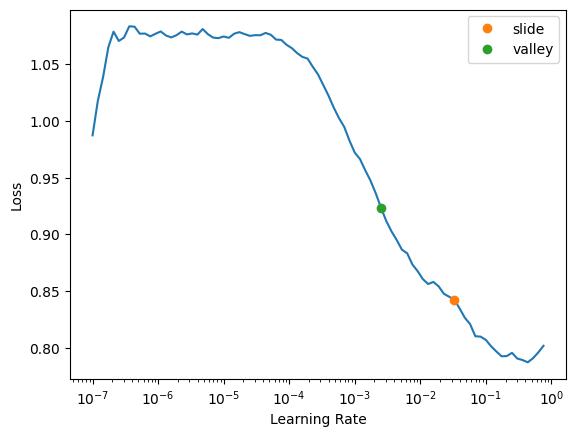

In [ ]:
learn = tabular_learner(dls, metrics=accuracy)
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
%%time
learn.fit_one_cycle(10,0.012)


epoch,train_loss,valid_loss,accuracy,time
0,0.487815,0.461404,0.821538,00:16
1,0.479131,0.455091,0.826962,00:12
2,0.481454,0.459068,0.825263,00:12
3,0.474665,0.447203,0.827158,00:12
4,0.454744,0.444762,0.827681,00:12
5,0.449095,0.445679,0.824806,00:13
6,0.445982,0.442614,0.828400,00:12
7,0.440536,0.441824,0.829118,00:12
8,0.450727,0.437887,0.830099,00:12
9,0.429696,0.437135,0.830687,00:13


CPU times: user 2min 7s, sys: 945 ms, total: 2min 8s
Wall time: 2min 11s


In [ ]:
%%time
dl = learn.dls.test_dl(test_df)
#nn_preds = learn.get_preds(dl=dl)
#nn_preds_x = learn.get_preds()[0]
#a_preds, _ = learn.get_preds(dl=dl)
#nn_preds_y = a_preds.squeeze(1)
#nn_preds_z = nn_preds[0]

#target_preds = nn_preds[0]

#test_df['Rings'] = target_preds
#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()

CPU times: user 69.2 ms, sys: 8.96 ms, total: 78.1 ms
Wall time: 145 ms


In [ ]:
target_preds = (nn_preds = learn.get_preds(dl=dl))[0]

test_df['Rings'] = target_preds
test_df.to_csv('submission.csv', columns=['Rings'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (<ipython-input-47-c5606faad9ca>, line 1)

In [ ]:
nn_preds = learn.get_preds(dl=dl)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


With original dataset added

In [ ]:
train_final = pd.concat([train_df,original_df], axis=0)
test_final = pd.concat([test_df,original_df.drop('Target',axis=1)],axis=0)
train_final.shape,test_final.shape

# Scoring

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

In [ ]:
!rm submission.csv